In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [3]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [4]:
# Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [5]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2772, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)
tourney_data['train_rec'] = 0
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 10 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
train_rec       2117 non-null int64
dtypes: int64(5), object(5)
memory usage: 165.5+ KB


### Extract some historical data

In [8]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [9]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data in this set goes back to 2010. If more training data is needed we can go back to earlier seasons.

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [10]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [11]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,0,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,0,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,0,1,2010
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,0,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,0,1,2010
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,0,1,2015


In [12]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010


In [13]:
tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season,Game Result,School,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22


In [14]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))


In [15]:
tourney_data.drop(columns=['School_t','School_o','Games_t','Games_o','team_id_o'],inplace=True)
tourney_data.head()

,season_t,round,game_date,seed_t,team,team_id_t,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


Incorporate additional features here.
Team conference, seeding deltas.

In [16]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [17]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)
tourney_data.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


In [18]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [19]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,NC State,28,32.0,35.0,32.0,33.0,24,2013,0.705882,52df1e19-b142-4a76-a439-ad68455d0581
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,Temple,32,27.0,38.0,25.0,30.0,45,2011,0.781250,8598d1b6-106b-4083-a512-2e495729525a
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,Akron,59,50.0,54.0,46.0,42.0,60,2013,0.812500,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,VA Commonwealth,54,35.0,47.0,33.0,38.0,55,2012,0.823529,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,Kansas,2,1.0,3.0,2.0,1.0,3,2011,0.942857,fae4855b-1b64-4b40-a632-9ed345e1e952


In [20]:
temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [21]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [22]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,0,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,0,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,0,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,0,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [23]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [24]:
tourney_comp_ratings['srs_sqr_t'] = tourney_comp_ratings['SRS_t'] * tourney_comp_ratings['SRS_t'] 
tourney_comp_ratings['srs_sqr_o'] = tourney_comp_ratings['SRS_o'] * tourney_comp_ratings['SRS_o'] 
tourney_comp_ratings['off_rating_sqr_t'] = tourney_comp_ratings['off_rating_t'] * tourney_comp_ratings['off_rating_t'] 
tourney_comp_ratings['off_rating_sqr_o'] =tourney_comp_ratings['off_rating_o'] * tourney_comp_ratings['off_rating_o'] 



In [25]:
numeric_feature_to_scale = ['pts_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'to_avg_t','steal_avg_t',
                            'SRS_t', 'SAG_t', 'WLK_t', 'RTH_t', 'COL_t', 'POM_t', 'DOL_t', 'RPI_t', 'MOR_t',
                            'off_rating_t',
                            'pts_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'to_avg_o','steal_avg_o',
                            'SRS_o',
                            'off_rating_o',
                            'srs_sqr_t','srs_sqr_o','off_rating_sqr_t','off_rating_sqr_o']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,-0.309298,-0.944152,0.564366,-0.512594
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,-0.599033,-0.642088,-0.580318,-0.653018
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,-1.077425,0.167481,-1.058146,-0.343703
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,-1.014051,0.271334,-1.226306,0.783481
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,1.762790,-1.043280,1.178463,-0.227863


In [27]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','team_t','team_id_t',
                                         'team_o','team_id_o','game_result','start_season','Game Result',
                                         'conf_name_t','conf_name_o','train_rec']).copy()
feature_data.head()

,season_t,seed_t,seed_o,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
0,2013,8,9,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,-0.309298,-0.944152,0.564366,-0.512594
1,2011,7,10,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,-0.599033,-0.642088,-0.580318,-0.653018
2,2013,12,5,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,-1.077425,0.167481,-1.058146,-0.343703
3,2012,12,5,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,-1.014051,0.271334,-1.226306,0.783481
4,2011,1,11,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,1.762790,-1.043280,1.178463,-0.227863


In [28]:
X= feature_data[feature_data['season_t']>=2010]
y= tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

#X= feature_data
#y= tourney_data['game_result']


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 63)
(426,)
(107, 63)
(107,)


,seed_t,seed_o,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
140,3,14,0.364401,9.56,0.676,-0.086174,0.320302,0.499,0.417,0.711,-0.033247,75.200000,-1.086891,0.567120,-0.368507,-1.786077,0.979063,-0.199045,0.360932,-0.777260,2009,-1.251048,-0.03,0.595,0.120882,0.977536,0.430,0.418,0.719,0.698445,80.518919,0.055431,1.401103,0.573110,1.835234,0.391126,0.538822,-0.691496,0.757135,11,9.0,14,9,12.0,11.0,16.0,7.0,7,112,91.0,119,116,106.0,100.0,126.0,95.0,101,0,1,0.159212,-1.343002,0.338257,-0.707030
293,5,4,0.140878,8.17,0.757,-0.507560,-0.323119,0.471,0.406,0.685,-0.387661,78.043243,1.202883,-0.145793,0.524285,-1.786077,0.979063,-0.199045,-0.866145,-0.399956,2009,0.483214,7.95,0.727,1.118256,0.758985,0.471,0.394,0.729,-0.016773,82.139394,0.602560,2.869712,0.573110,0.663761,-0.268590,0.538822,0.158669,-0.344465,25,28.0,30,22,26.0,24.0,20.0,28.0,18,15,14.0,25,19,23.0,10.0,19.0,24.0,10,0,0,-0.144156,0.337619,-0.872689,0.133314
368,13,4,-1.397485,0.45,0.618,-1.350330,-0.537592,0.461,0.394,0.684,0.321167,72.452941,-1.086891,0.567120,0.524285,0.010110,-0.319048,-0.990771,-0.564648,-2.286475,2014,0.531862,8.98,0.750,-1.075966,-1.207979,0.429,0.392,0.668,-0.016773,77.022222,0.602560,0.666798,0.141048,0.663761,-0.268590,0.538822,-1.411088,0.389935,97,103.0,103,113,107.0,94.0,112.0,88.0,103,15,15.0,13,12,15.0,18.0,14.0,21.0,13,-1,1,-1.367465,0.413417,-0.582434,-1.388465
53,3,11,0.551108,8.45,0.757,0.545903,0.320302,0.449,0.407,0.672,-0.033247,80.497297,0.630440,-0.145793,1.417076,1.207568,-0.319048,0.592680,-0.174492,0.354651,2015,-0.696189,4.44,0.639,-1.075966,-0.333773,0.455,0.423,0.757,-1.804820,68.727778,-3.227338,-0.801811,0.141048,1.835234,-1.588022,-0.915315,0.708281,-1.446065,17,16.0,26,21,13.0,17.0,17.0,17.0,12,73,87.0,89,92,87.0,77.0,85.0,70.0,66,1,1,0.437045,-1.021493,-0.199789,0.696904
33,3,1,0.860096,8.38,0.846,0.967289,0.105828,0.481,0.403,0.712,-1.096490,77.917949,-0.514447,-0.145793,0.970681,0.010110,-0.319048,-0.199045,0.970689,-0.399956,2016,1.243186,12.23,0.861,1.916156,1.414639,0.488,0.420,0.678,-0.016773,82.350000,0.055431,0.666798,1.005171,0.663761,0.391126,-0.188247,1.075917,0.022735,13,14.0,8,11,7.0,16.0,12.0,9.0,24,6,5.0,5,3,2.0,10.0,2.0,3.0,8,0,0,0.945695,1.700296,0.969214,1.082798


In [30]:
# mark the records used for training
tourney_comp_ratings['train_rec'] = 0
tourney_comp_ratings.loc[X_train.index,'train_rec']= 1
#tourney_data.head(30)

In [31]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[ 7.60673944e-02 -1.06798137e-01  1.36368567e+00  2.43876528e-01
   1.18284560e+00 -2.84627868e-01 -7.74436694e-01 -8.50579063e-02
   5.05441818e-04 -2.38478733e-01  1.11666990e-01  3.19709662e-01
  -2.06455811e-01 -1.36939864e-01 -2.65438668e-01  1.99319087e-02
  -4.14998251e-02 -1.98922055e-01 -9.23928902e-03 -4.33212704e-01
  -8.46335831e-03 -1.29407559e+00 -7.15426887e-01 -1.54686157e+00
  -2.39889694e-01  1.27831951e+00 -1.26188466e-02  1.65244886e-01
  -1.70409052e-01  2.63026369e-01 -3.52742279e-02 -3.74906396e-01
  -3.22790527e-01 -3.98731039e-02  4.42497676e-02  9.58527967e-02
  -5.26107037e-01 -6.08595168e-01  5.37211472e-02  1.55904330e-02
   3.86090140e-03 -6.15337381e-02  1.00511425e-01 -6.00658912e-02
  -2.35829745e-03  1.92951093e-02  4.12099773e-02 -3.63830583e-02
  -2.08816836e-02  5.71905428e-02  9.41260061e-03 -1.23301113e-01
   7.98218975e-02 -1.46967370e-02  8.43794071e-03 -1.69008913e-02
  -2.67579303e-02 -3.75260434e-02 -3.83255989e-02  5.29076518e-01
  

In [32]:
display_important_features_regression(logreg, X_train)

Coefficient Values
win_pct_o   -1.5468615676693054
SRS_t   1.3636856747739574
SRS_o   -1.2940755898252239
opp_pts_avg_o   1.2783195116358068
win_pct_t   1.1828456027125396
opp_pts_avg_t   -0.7744366937010534
SOS_o   -0.715426886812816
off_rating_o   -0.6085951684794301
off_rating_sqr_o   -0.5872406855847464
srs_sqr_t   0.5290765181983027
steal_avg_o   -0.5261070372394062
srs_sqr_o   0.4412215255294246
ft_att_avg_t   -0.433212704336532
off_rebs_avg_o   -0.3749063963195278
allow_off_rebs_avg_o   -0.3227905274753529
poss_avg_t   0.31970966221506286
off_rating_sqr_t   0.3106673366004701
pts_avg_t   -0.28462786847667015
def_rebs_avg_t   -0.26543866819329615
allow_ft_att_avg_o   0.26302636935175017
SOS_t   0.24387652801451767
pts_avg_o   -0.23988969410035163
ft_pct_t   -0.2384787330192842
off_rebs_avg_t   -0.20645581098783522
steal_avg_t   -0.19892205508581384
ft_pct_o   -0.1704090516645132
allow_fg_pct_o   0.16524488616018104
allow_off_rebs_avg_t   -0.13693986386310622
RTH_o   -0.1233011132

In [33]:
y_pred = logreg.predict(X_test)
prediction_probabilities = logreg.predict_proba(X_test)
print("LR model prediction accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model prediction accuracy is 0.65


In [34]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.7021014204191173


In [ ]:
#X_2010 = feature_data[feature_data['season_t']==2010]
#y_2010 = tourney_data[tourney_data['season_t']==2010]['game_result']
#X_2010 = X_2010.drop(columns=['season_t'])
#print("2010 y sizes= ", y_2010.shape)
#print("2010 x sizes= ", X_2010.shape)

#y_pred_2010 = logreg.predict(X_2010)
#print("LR 2010 model prediction accuracy is %2.2f" % metrics.accuracy_score(y_2010, y_pred_2010))

In [ ]:
#cnf_matrix_2010 = metrics.confusion_matrix(y_2010, y_pred_2010)
#cnf_matrix_2010
#class_names=[0,1] # name  of classes
#fig, ax = plt.subplots()
#tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names)
#plt.yticks(tick_marks, class_names)
# create heatmap
#sns.heatmap(pd.DataFrame(cnf_matrix_2010), annot=True, cmap="YlGnBu" ,fmt='g')
#ax.xaxis.set_label_position("top")
#plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
#plt.ylabel('Actual label')
#plt.xlabel('Predicted label')

In [35]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[33, 19],
       [18, 37]], dtype=int64)

Text(0.5,257.44,'Predicted label')

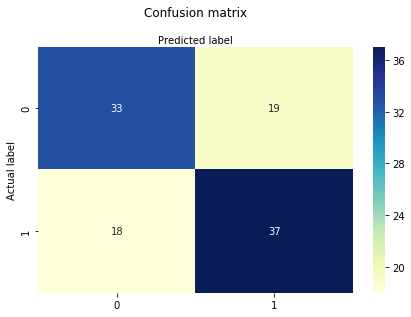

In [36]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6542056074766355
Precision: 0.6607142857142857
Recall: 0.6727272727272727
Log loss=  0.7021014204191173


In [38]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010,Win,8.56,3.78,0.700,71.0,66.0,0.434,0.424,0.715,18.0,75.240000,10.0,10.0,21.0,24.0,11.0,8.0,94.364700,20.0,2010,14.61,10.39,0.656,70.0,66.0,0.475,0.387,0.734,19.0,73.850000,10.0,10.0,23.0,19.0,13.0,6.0,94.786730,17.0,Atlantic 10,Big East,77,55.0,54,74,59.0,84.0,72.0,49.0,80,16,19.0,16,17,16.0,31.0,19.0,13.0,42,0,0,73.2736,213.4521,8904.696536,8984.524158,0,0.112029
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,0,0,2011,Lose,10.44,4.94,0.750,75.0,69.0,0.469,0.435,0.719,19.0,77.743750,10.0,11.0,21.0,22.0,12.0,7.0,96.470777,19.0,2011,9.20,7.29,0.611,59.0,56.0,0.437,0.386,0.705,16.0,69.133333,10.0,10.0,20.0,20.0,13.0,5.0,85.342334,16.0,American Athletic,American Athletic,36,29.0,28,35,22.0,34.0,20.0,20.0,42,70,51.0,60,53,59.0,66.0,60.0,52.0,47,0,1,108.9936,84.6400,9306.610890,7283.313913,0,0.216629
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,0,0,2016,Lose,12.88,4.62,0.714,73.0,65.0,0.454,0.406,0.668,24.0,77.840000,11.0,10.0,25.0,23.0,11.0,6.0,93.782117,22.0,2016,20.80,8.38,0.846,78.0,65.0,0.481,0.403,0.712,15.0,77.917949,10.0,10.0,26.0,22.0,11.0,6.0,100.105305,20.0,Atlantic 10,Pacific 12,48,40.0,48,53,43.0,37.0,52.0,31.0,31,13,14.0,8,11,7.0,16.0,12.0,9.0,24,-1,1,165.8944,432.6400,8795.085499,10021.072029,0,0.118514
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,0,0,2012,Lose,-3.21,-5.80,0.588,78.0,76.0,0.479,0.468,0.691,19.0,80.676471,11.0,11.0,19.0,21.0,14.0,6.0,96.682464,25.0,2012,-1.73,-2.28,0.583,65.0,64.0,0.421,0.428,0.699,20.0,72.988889,10.0,10.0,19.0,24.0,11.0,7.0,89.054651,19.0,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,10.3041,2.9929,9347.498932,7930.730799,1,0.821490
43,2017,64,2017-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,1,2016,Win,16.75,2.19,0.853,72.0,57.0,0.496,0.412,0.745,14.0,69.458824,9.0,7.0,25.0,19.0,10.0,4.0,103.658537,14.0,2016,11.57,3.77,0.743,74.0,66.0,0.461,0.422,0.705,22.0,79.537143,11.0,9.0,25.0,24.0,12.0,7.0,93.038293,21.0,West Coast,Atlantic 10,25,25.0,11,20,18.0,14.0,23.0,17.0,26,50,43.0,46,54,30.0,52.0,44.0,22.0,50,0,0,280.5625,133.8649,10745.092210,8656.123961,1,0.765073


In [40]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
missed_predictions[['predicted_result','game_result','pred_win_prob','team_t','seed_t','conf_name_t', 'team_o','seed_o', 
                    'conf_name_o','top_conf','season_t','round']]

print("Total missed predictions= ", missed_predictions.shape[0])

missed_predictions

Total missed predictions=  37


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o,predicted_result,pred_win_prob
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,0,0,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.424,0.673,27.0,85.394286,15.0,8.0,23.0,22.0,14.0,9.0,91.341006,27.0,2015,9.23,-5.47,0.824,80.0,63.0,0.478,0.438,0.735,20.0,80.100000,11.0,9.0,23.0,22.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,466.9921,85.1929,8343.179454,9975.046796,1,0.987442
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,0,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.406,0.731,16.0,73.861111,10.0,10.0,24.0,21.0,10.0,7.0,102.895826,22.0,2014,14.11,9.72,0.611,70.0,65.0,0.436,0.403,0.686,19.0,75.550000,12.0,11.0,25.0,23.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,534.9969,199.0921,10587.550905,8584.739924,1,0.892511
486,2014,68,2014-03-18,16,Mount St. Mary's,5fe4a398-1699-4442-a364-305b2f0ac01e,16,Albany,290a5130-836d-45e6-824f-28704d6ba246,0,0,2013,Lose,-6.32,-4.44,0.485,75.0,77.0,0.438,0.495,0.739,20.0,78.587879,9.0,10.0,21.0,25.0,11.0,7.0,95.434565,21.0,2013,-3.31,-5.22,0.559,65.0,63.0,0.441,0.419,0.750,15.0,72.123529,10.0,9.0,24.0,21.0,12.0,5.0,90.123155,21.0,Northeast,America East,215,219.0,203,229,220.0,188.0,223.0,189.0,186,185,196.0,201,224,211.0,177.0,187.0,185.0,157,0,0,39.9424,10.9561,9107.756132,8122.183017,1,0.874093
496,2017,32,2017-03-18,5,Iowa State,0e4258fa-3154-4c16-b693-adecab184c6c,4,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,0,0,2016,Lose,20.51,11.94,0.686,80.0,72.0,0.472,0.428,0.700,15.0,79.502857,9.0,11.0,25.0,26.0,10.0,7.0,100.625315,17.0,2016,20.13,8.79,0.771,79.0,68.0,0.479,0.421,0.757,14.0,79.171429,9.0,8.0,27.0,22.0,13.0,5.0,99.783472,19.0,Big 12,Big Ten,16,19.0,23,21,27.0,17.0,15.0,21.0,11,12,11.0,18,14,17.0,15.0,19.0,19.0,13,0,0,420.6601,405.2169,10125.453918,9956.741219,1,0.861820
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,0,0,2012,Lose,-3.21,-5.80,0.588,78.0,76.0,0.479,0.468,0.691,19.0,80.676471,11.0,11.0,19.0,21.0,14.0,6.0,96.682464,25.0,2012,-1.73,-2.28,0.583,65.0,64.0,0.421,0.428,0.699,20.0,72.988889,10.0,10.0,19.0,24.0,11.0,7.0,89.054651,19.0,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,10.3041,2.9929,9347.498932,7930.730799,1,0.821490
292,2010,8,2010-03-28,6,Tennessee,b827dbdf-230f-4916-9703-3bb9004e26eb,5,Michigan State,a41d5a05-4c11-4171-a57e-e7a1ea325a6d,0,0,2009,Lose,16.05,7.75,0.757,73.0,65.0,0.456,0.396,0.671,22.0,80.378378,11.0,11.0,24.0,23.0,13.0,7.0,90.820444,20.0,2009,15.33,8.17,0.757,71.0,63.0,0.471,0.406,0.685,17.0,78.043243,13.0,10.0,25.0,19.0,13.0,6.0,90.975204,20.0,Southeastern,Big Ten,19,22.0,17,20,16.0,35.0,17.0,14.0,27,25,28.0,30,22,26.0,24.0,20.0,28.0,18,0,0,257.6025,235.0089,8248.353021,8276.487801,1,0.783863
366,2012,64,2012-03-15,6,UNLV,68a3227f-677f-43b0-9a3a-cad79d0df9e2,11,Colorado,9fccbf28-2858-4263-821c-fdefb3c7efa3

### Missed Prediction Analysis

#### Type I Errors

In [41]:
type_1_cond = (missed_predictions['predicted_result'] == 1) &  (missed_predictions['game_result'] == 0)
t1_errors = missed_predictions[type_1_cond]
t1_errors

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o,predicted_result,pred_win_prob
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,0,0,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.424,0.673,27.0,85.394286,15.0,8.0,23.0,22.0,14.0,9.0,91.341006,27.0,2015,9.23,-5.47,0.824,80.0,63.0,0.478,0.438,0.735,20.0,80.100000,11.0,9.0,23.0,22.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,466.9921,85.1929,8343.179454,9975.046796,1,0.987442
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,0,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.406,0.731,16.0,73.861111,10.0,10.0,24.0,21.0,10.0,7.0,102.895826,22.0,2014,14.11,9.72,0.611,70.0,65.0,0.436,0.403,0.686,19.0,75.550000,12.0,11.0,25.0,23.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,534.9969,199.0921,10587.550905,8584.739924,1,0.892511
486,2014,68,2014-03-18,16,Mount St. Mary's,5fe4a398-1699-4442-a364-305b2f0ac01e,16,Albany,290a5130-836d-45e6-824f-28704d6ba246,0,0,2013,Lose,-6.32,-4.44,0.485,75.0,77.0,0.438,0.495,0.739,20.0,78.587879,9.0,10.0,21.0,25.0,11.0,7.0,95.434565,21.0,2013,-3.31,-5.22,0.559,65.0,63.0,0.441,0.419,0.750,15.0,72.123529,10.0,9.0,24.0,21.0,12.0,5.0,90.123155,21.0,Northeast,America East,215,219.0,203,229,220.0,188.0,223.0,189.0,186,185,196.0,201,224,211.0,177.0,187.0,185.0,157,0,0,39.9424,10.9561,9107.756132,8122.183017,1,0.874093
496,2017,32,2017-03-18,5,Iowa State,0e4258fa-3154-4c16-b693-adecab184c6c,4,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,0,0,2016,Lose,20.51,11.94,0.686,80.0,72.0,0.472,0.428,0.700,15.0,79.502857,9.0,11.0,25.0,26.0,10.0,7.0,100.625315,17.0,2016,20.13,8.79,0.771,79.0,68.0,0.479,0.421,0.757,14.0,79.171429,9.0,8.0,27.0,22.0,13.0,5.0,99.783472,19.0,Big 12,Big Ten,16,19.0,23,21,27.0,17.0,15.0,21.0,11,12,11.0,18,14,17.0,15.0,19.0,19.0,13,0,0,420.6601,405.2169,10125.453918,9956.741219,1,0.861820
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,0,0,2012,Lose,-3.21,-5.80,0.588,78.0,76.0,0.479,0.468,0.691,19.0,80.676471,11.0,11.0,19.0,21.0,14.0,6.0,96.682464,25.0,2012,-1.73,-2.28,0.583,65.0,64.0,0.421,0.428,0.699,20.0,72.988889,10.0,10.0,19.0,24.0,11.0,7.0,89.054651,19.0,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,10.3041,2.9929,9347.498932,7930.730799,1,0.821490
292,2010,8,2010-03-28,6,Tennessee,b827dbdf-230f-4916-9703-3bb9004e26eb,5,Michigan State,a41d5a05-4c11-4171-a57e-e7a1ea325a6d,0,0,2009,Lose,16.05,7.75,0.757,73.0,65.0,0.456,0.396,0.671,22.0,80.378378,11.0,11.0,24.0,23.0,13.0,7.0,90.820444,20.0,2009,15.33,8.17,0.757,71.0,63.0,0.471,0.406,0.685,17.0,78.043243,13.0,10.0,25.0,19.0,13.0,6.0,90.975204,20.0,Southeastern,Big Ten,19,22.0,17,20,16.0,35.0,17.0,14.0,27,25,28.0,30,22,26.0,24.0,20.0,28.0,18,0,0,257.6025,235.0089,8248.353021,8276.487801,1,0.783863
366,2012,64,2012-03-15,6,UNLV,68a3227f-677f-43b0-9a3a-cad79d0df9e2,11,Colorado,9fccbf28-2858-4263-821c-fdefb3c7efa3

In [44]:
for index, row in t1_errors.iterrows():
    utils.print_game_info(test_games, row['season_t'], row['round'], row['team_t'])
    print("------\n")

                                West Virginia          Stephen F. Austin     Stat Upset
Seed                              3                                 14           True  (L)
SAG                              6.00                              57.00         True  (L)
WLK                              6.00                              55.00         True  (L)
WOL                              8.00                              62.00         True  (L)
RTH                              8.00                             101.00         True  (L)
COL                             11.00                              83.00         True  (L)
POM                              6.00                              33.00         True  (L)
DOL                              7.00                              80.00         True  (L)
RPI                             10.00                              62.00         True  (L)
MOR                             11.00                              36.00         True  (L)
Al

In [45]:
y_train.shape

(426,)

#### Type II Errors

#### Missed predictions where higher seed was upset

In [49]:
f_list=['season_t','round', 'seed_t','SRS_t','team_t','team_o','seed_o','SRS_o','game_result','predicted_result']

cond_1 = ((missed_predictions['seed_t'] > missed_predictions['seed_o']) & 
          (missed_predictions['game_result'] == 1))

cond_2 = ((missed_predictions['seed_t'] < missed_predictions['seed_o']) &  
          (missed_predictions['game_result'] == 0))

upset_seeds = missed_predictions[cond_2 | cond_1][f_list]
print("Total missed predictions with seeding upset= ", upset_seeds.shape[0])
upset_seeds

Total missed predictions with seeding upset=  22


,season_t,round,seed_t,SRS_t,team_t,team_o,seed_o,SRS_o,game_result,predicted_result
488,2016,64,3,21.61,West Virginia,Stephen F. Austin,14,9.23,0,1
358,2015,32,1,23.13,Villanova,North Carolina State,8,14.11,0,1
366,2012,64,6,13.55,UNLV,Colorado,11,7.91,0,1
394,2013,32,12,14.42,Ole Miss,La Salle,13,10.14,0,1
116,2010,64,7,15.71,Clemson,Missouri,10,17.39,0,1
514,2013,16,2,16.99,Miami (FL),Marquette,3,14.04,0,1
440,2012,64,7,11.18,Notre Dame,Xavier,10,9.59,0,1
208,2010,16,1,21.72,Syracuse,Butler,5,14.37,0,1
283,2013,8,9,14.68,Wichita State,Ohio State,2,20.19,1,0
111,2013,64,12,14.42,Ole Miss,Wisconsin,5,18.76,1,0


In [50]:
for index, row in upset_seeds.iterrows():
    utils.print_game_info(test_games, row['season_t'], row['round'], row['team_t'])
    print("------\n")



                                West Virginia          Stephen F. Austin     Stat Upset
Seed                              3                                 14           True  (L)
SAG                              6.00                              57.00         True  (L)
WLK                              6.00                              55.00         True  (L)
WOL                              8.00                              62.00         True  (L)
RTH                              8.00                             101.00         True  (L)
COL                             11.00                              83.00         True  (L)
POM                              6.00                              33.00         True  (L)
DOL                              7.00                              80.00         True  (L)
RPI                             10.00                              62.00         True  (L)
MOR                             11.00                              36.00         True  (L)
Al

In [51]:
tourney_comp_ratings[((tourney_comp_ratings['team_t']=='Missouri') & (tourney_comp_ratings['train_rec']==1))]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
10,2013,64,2013-03-21,9,Missouri,77ca152a-cb2f-48a5-97b2-492351250d94,8,Colorado State,1a470730-f328-4fb1-8bbf-36a069e4d6b2,1,0,2012,Lose,0.151397,6.00,0.676,0.545903,0.320302,0.459,0.403,0.744,-0.387661,80.570588,1.202883,-0.145793,-0.368507,-0.588619,0.979063,-0.199045,-0.191771,-0.399956,2012,-0.055867,5.89,0.743,-0.278067,-0.333773,0.449,0.414,0.715,0.340836,76.914286,1.696816,-1.536116,-0.723075,-1.093448,-0.268590,-1.642383,-0.351989,1.124334,Southeastern,Mountain West,16,24.0,46,36,44.0,18.0,36.0,36.0,17,36,29.0,21,32,22.0,24.0,28.0,21.0,40,1,0,-0.130595,-0.397638,-0.216902,-0.376025
284,2012,64,2012-03-16,2,Missouri,77ca152a-cb2f-48a5-97b2-492351250d94,15,Norfolk State,a8f75c12-c4db-401f-99e3-b48209d85274,1,0,2011,Lose,0.724667,5.68,0.857,1.388674,0.320302,0.504,0.444,0.766,-1.096490,74.142857,-1.086891,-0.145793,-1.707694,-1.187348,-0.968104,1.384405,2.538822,-0.399956,2011,-2.334468,-5.39,0.722,-1.075966,0.540433,0.440,0.412,0.656,1.056054,79.100000,0.055431,0.666798,-1.155136,0.078025,1.710558,-0.188247,-1.872378,0.757135,Southeastern,Mid Eastern Athletic,7,7.0,3,3,7.0,7.0,3.0,10.0,7,182,187.0,127,172,117.0,214.0,126.0,128.0,236,1,1,0.715257,-1.384415,2.680951,-1.810902
504,2010,32,2010-03-21,10,Missouri,77ca152a-cb2f-48a5-97b2-492351250d94,2,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,1,0,2009,Lose,0.411735,6.36,0.676,0.756596,0.320302,0.440,0.410,0.724,1.029996,82.988235,0.630440,1.992944,-0.814903,1.207568,0.330008,2.967856,-0.502196,-0.022652,2009,0.668605,10.26,0.816,-0.278067,-0.333773,0.430,0.417,0.704,0.698445,78.636842,2.243944,-0.067506,-0.291013,-0.507711,-0.268590,-0.915315,-0.759868,0.389935,Southeastern,Big 12,21,34.0,36,26,42.0,21.0,38.0,44.0,28,5,5.0,4,5,4.0,8.0,5.0,4.0,9,0,1,0.227544,0.634846,-0.521718,-0.772953


#### Missed predictions where Lower SRS Won Game

In [52]:
cond_srs_1 = ((missed_predictions['SRS_t'] > missed_predictions['SRS_o']) & 
          (missed_predictions['game_result'] == 0))

cond_srs_2 = ((missed_predictions['SRS_t'] < missed_predictions['SRS_o']) & 
          (missed_predictions['game_result'] == 1))

upset_srs = missed_predictions[cond_srs_1 | cond_srs_2][f_list]
print("Total missed predictions with SRS upset= ", upset_srs.shape[0])
upset_srs

Total missed predictions with SRS upset=  23


,season_t,round,seed_t,SRS_t,team_t,team_o,seed_o,SRS_o,game_result,predicted_result
488,2016,64,3,21.61,West Virginia,Stephen F. Austin,14,9.23,0,1
358,2015,32,1,23.13,Villanova,North Carolina State,8,14.11,0,1
496,2017,32,5,20.51,Iowa State,Purdue,4,20.13,0,1
292,2010,8,6,16.05,Tennessee,Michigan State,5,15.33,0,1
366,2012,64,6,13.55,UNLV,Colorado,11,7.91,0,1
394,2013,32,12,14.42,Ole Miss,La Salle,13,10.14,0,1
514,2013,16,2,16.99,Miami (FL),Marquette,3,14.04,0,1
440,2012,64,7,11.18,Notre Dame,Xavier,10,9.59,0,1
208,2010,16,1,21.72,Syracuse,Butler,5,14.37,0,1
283,2013,8,9,14.68,Wichita State,Ohio State,2,20.19,1,0


In [53]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

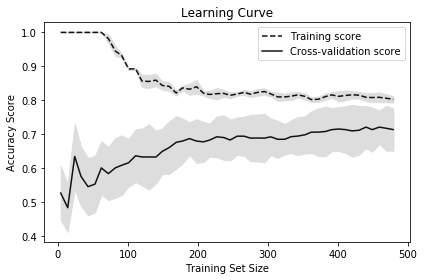

In [54]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Cross validation error

In [55]:

scores = cross_val_score(LogisticRegression(), X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.7135757673493524


### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg,20)
fit = rfe.fit(X,y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

In [ ]:
X_train.iloc[:,fit.support_]